# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

# Task 1: Read the _hourly_ data and split into training and test data.

##Start of Answer 1##

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler,MaxAbsScaler
from sklearn.linear_model import Ridge
from statsmodels.graphics.gofplots import qqplot


# Load Dataset

In [2]:
df = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
print("Hourly", df.shape)
df.head(5)

Hourly (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


 ## Check  if  there are any NaNs in dataset      

In [3]:
print("Missing Data : " + str(df.isnull().values.any()))

Missing Data : False


### Check dataframe data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
df = df.rename(columns={ 'dteday':'date',
                        'weathersit':'weather',
                       'yr':'year',
                       'mnth':'month',
                       'hr':'hour',
                       'hum':'humidity',
                       'cnt':'count'})
df.columns.values

array(['instant', 'date', 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'count'], dtype=object)

#### Data types are mostly numerical aside from the date however we wont be using the date so there is no need of changing it. Since there are no nulls and data types are ok there isnt anything to cleanup

 # Split into Test and Training

### Set Feautures and Targets

In [6]:
X, y = df[['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather',
 'temp', 'atemp', 'humidity', 'windspeed']], df[['casual', 'registered', 'count']]
print("Features : ", X.columns.values)
print("Targets : ", y.columns.values)

Features :  ['season' 'year' 'month' 'hour' 'holiday' 'weekday' 'workingday' 'weather'
 'temp' 'atemp' 'humidity' 'windspeed']
Targets :  ['casual' 'registered' 'count']


### Split Data Into Train and Test 6:4

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=666)

##End of Answer 1##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

### Checking for data skewness

[Text(0.5, 1.0, 'Theoritical quantiles')]

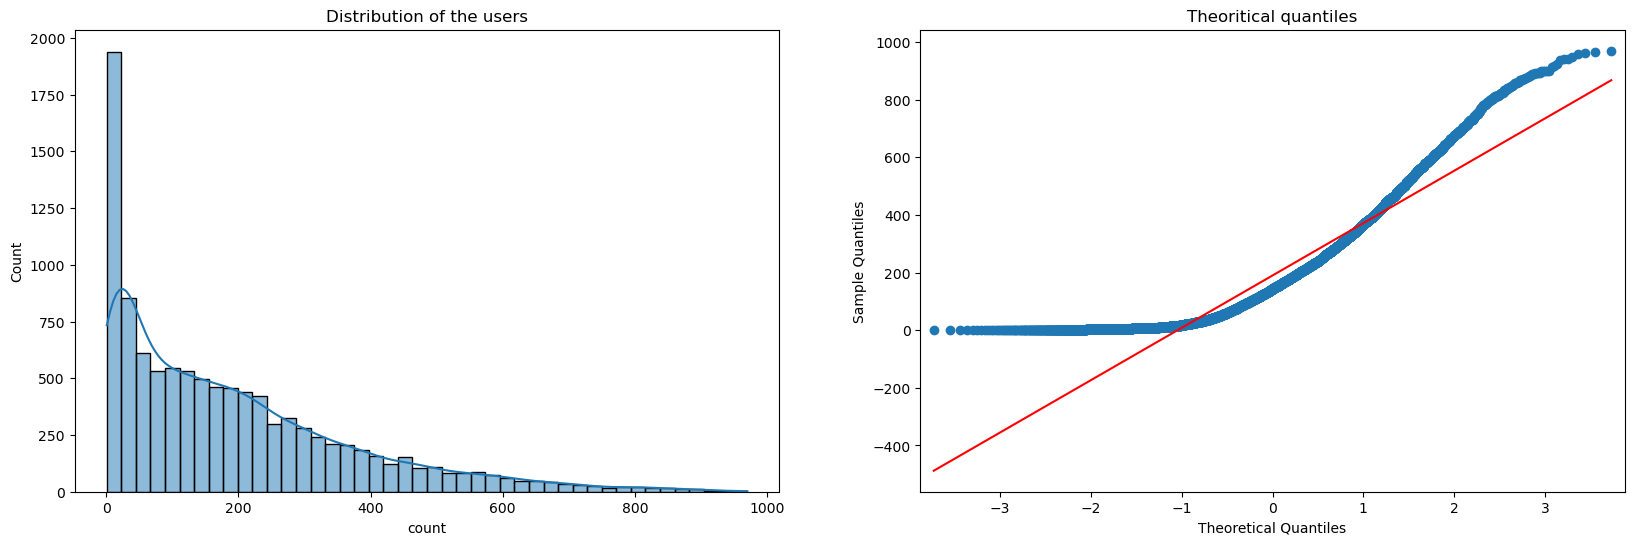

In [8]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.histplot(y_train['count'], kde=True, ax=ax1)
ax1.set(title='Distribution of the users')
qqplot(y_train['count'], ax=ax2, line='s')
ax2.set(title='Theoritical quantiles')

#### Data seems to have a positive skew

### Transforming count using log transformation

##Start of Answer 2##

In [9]:
y_train['count'] = np.log(y_train['count'])
y_test['count'] = np.log(y_test['count'])

[Text(0.5, 1.0, 'Theoritical quantiles')]

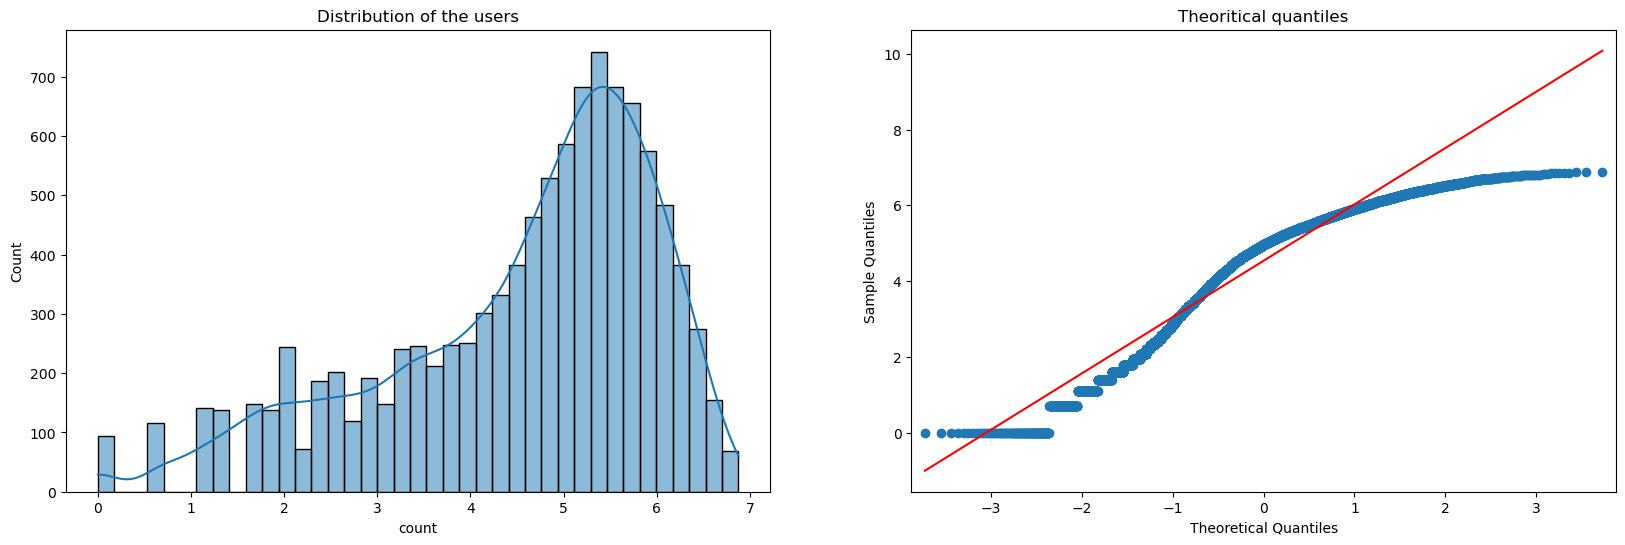

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.histplot(y_train['count'], kde=True, ax=ax1)
ax1.set(title='Distribution of the users')
qqplot(y_train['count'], ax=ax2, line='s')
ax2.set(title='Theoritical quantiles')

#### Data now seems to be more simmetrical ,but still slight skewed (negatively) , this is ok for now as achieving a fyly symetrical dataset would be time consuming and hard

#### Note: Log transformation wasnt done for registered and casual as they contain non zero values, this causes NaN value error when fitting the model. A solution for this would be to drop the rows that contain the NaN values however this would remove too much data and since count seems to be the best predictor (next best predictor further below) there is no need to do this.

### Convert training data into dataframe (joining of features and targets)

In [11]:
df_train = pd.DataFrame()
df_train=X_train.copy()
df_train = df_train.join(y_train.copy())

df_train = df_train.sort_values(by=['year','month','weekday','hour'],ascending=True)

print("Size Before Split:", df.shape)
print("Size After Split:", df_train.shape)

df_train.head(5)

Size Before Split: (17379, 17)
Size After Split: (10427, 15)


,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
641,1,0,1,0,0,0,0,1,0.16,0.1818,0.80,0.1045,0,33,3.496508
24,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,4,13,2.833213
185,1,0,1,0,0,0,0,1,0.10,0.0758,0.42,0.3881,1,24,3.218876
642,1,0,1,1,0,0,0,1,0.14,0.2121,0.80,0.0000,7,22,3.367296
349,1,0,1,1,0,0,0,1,0.26,0.2727,0.56,0.1343,4,19,3.135494


### Convert testing data into dataframe (joining of features and targets)

In [12]:
df_test = pd.DataFrame()
df_test = X_test.copy()
df_test = df_test.join(y_test.copy())

df_test = df_test.sort_values(by=['year','month','weekday','hour'],ascending=True)

print("Size Before Split:", df.shape)
print("Size After Split:", df_test.shape)

df_test.head(5)

Size Before Split: (17379, 17)
Size After Split: (6952, 15)


,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
502,1,0,1,0,0,0,0,1,0.04,0.0758,0.57,0.1045,2,20,3.091042
348,1,0,1,0,0,0,0,1,0.26,0.3030,0.56,0.0000,6,33,3.663562
187,1,0,1,2,0,0,0,1,0.10,0.0606,0.46,0.4627,0,11,2.397895
26,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,1,8,2.197225
505,1,0,1,3,0,0,0,1,0.02,0.0606,0.62,0.1343,1,4,1.609438


<AxesSubplot:xlabel='weather', ylabel='count'>

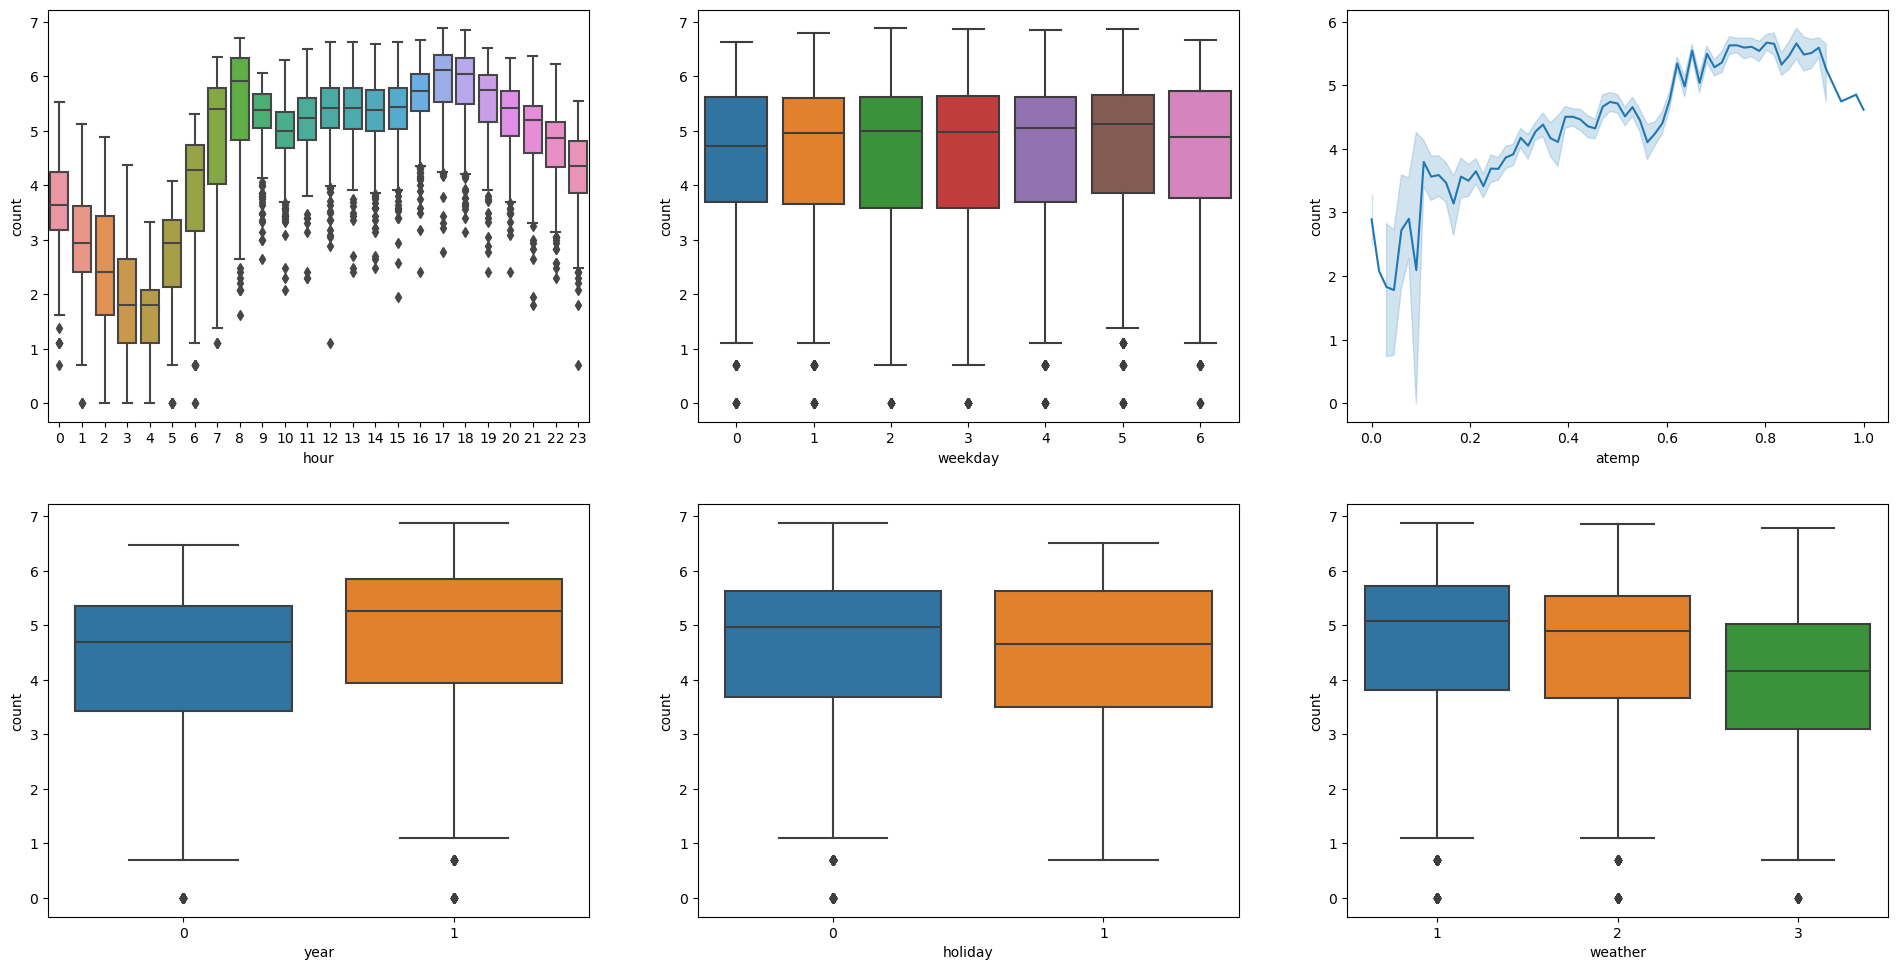

In [13]:
fig ,axes = plt.subplots(2, 3)

# set the spacing between subplots
plt.subplots_adjust(right=3, top=2)

sns.boxplot(data=df_train, x="hour", y="count", ax=axes[0,0])

sns.boxplot(data=df_train, x="weekday", y="count", ax=axes[0,1])

sns.lineplot(data=df_train, x="atemp", y="count", ax=axes[0,2])

sns.boxplot(data=df_train, x="year", y="count", ax=axes[1,0])

sns.boxplot(data=df_train, x="holiday", y="count", ax=axes[1,1])

sns.boxplot(data=df_train, x="weather", y="count", ax=axes[1,2])

-  From the boxplots we can see that the mean bikes rented per day is roughly the same during the week however it slightly decreases on weekends (0,6). 
- The night hours from 10pm-6am tend to have the lowest mean for bikes rented by the hour, the hihghest means are seen around the start and finish of busines hours ie ~8am and ~5pm, the mean then decreases for the duration of business dat ~10am to ~3pm however it is still higher then the night hours. 
- From the lineplot we can see that the average number of bikes rented increases with the temperature to a point and after a certain point it decreases significantly.
- We can also see that the median number of bikes renters was sloghtly higher in more recent year.
- From the holiday boxplot we can also see the the mean is slightly lower during holidays
- The weathersit or weathersitatuin also has a clear decrease of the average count as we move from 1 - 3 , this shows that more people rent bikes when the weather situatuion is clearer with fewerr clouds (1) when compared to misty conditions (2) and raining, snowing or thunderstorm conditions (3)

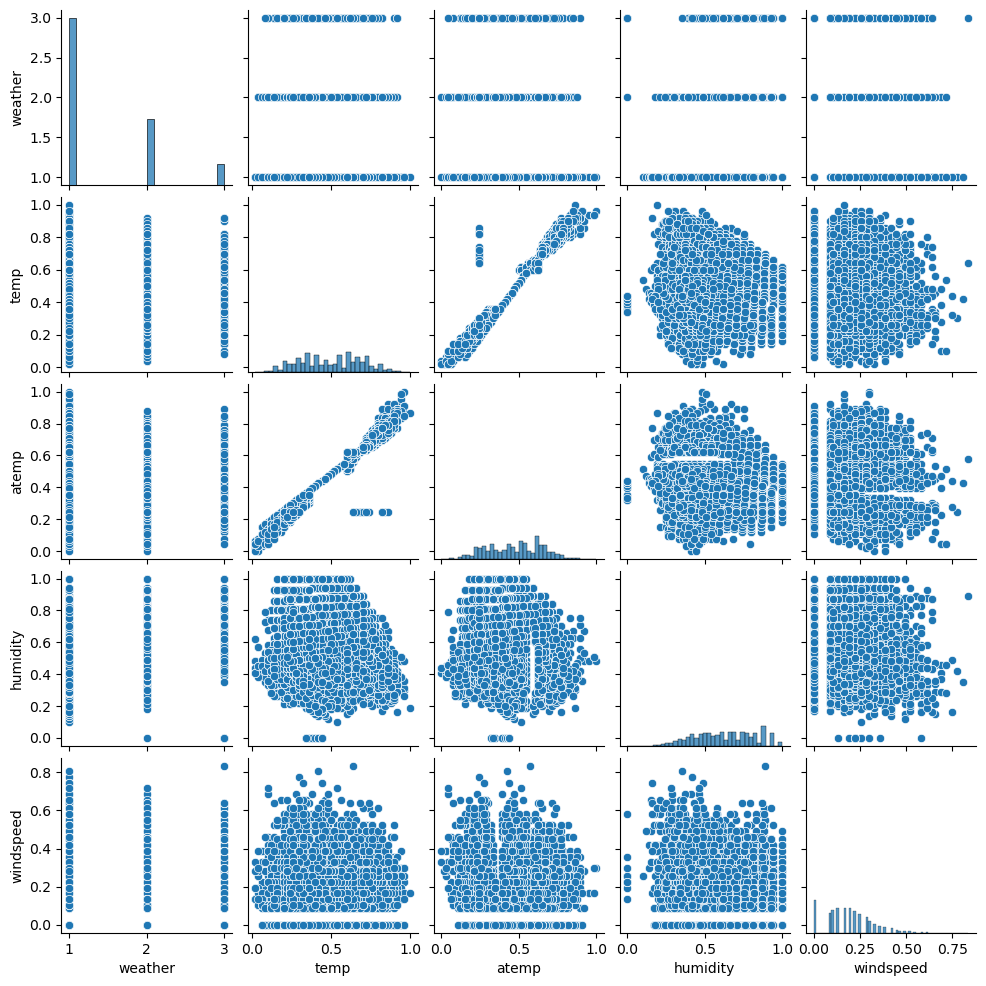

In [14]:
 sns.pairplot(df_train, vars=['weather', 'temp', 'atemp', 'humidity', 'windspeed'], height=2)

#### From the pairplot we can see that there is a clear relationship between two of our feautures temp and atemp , this means we can drop one of these as they have a high corelation.

#### Using Spearmans and Pearsons Corelations to spot any more corelations between features and also to spot any features that might be good predictors for the target ie have lowcorrelation with other candidate predictors.

<AxesSubplot:title={'center':'Pearsons'}>

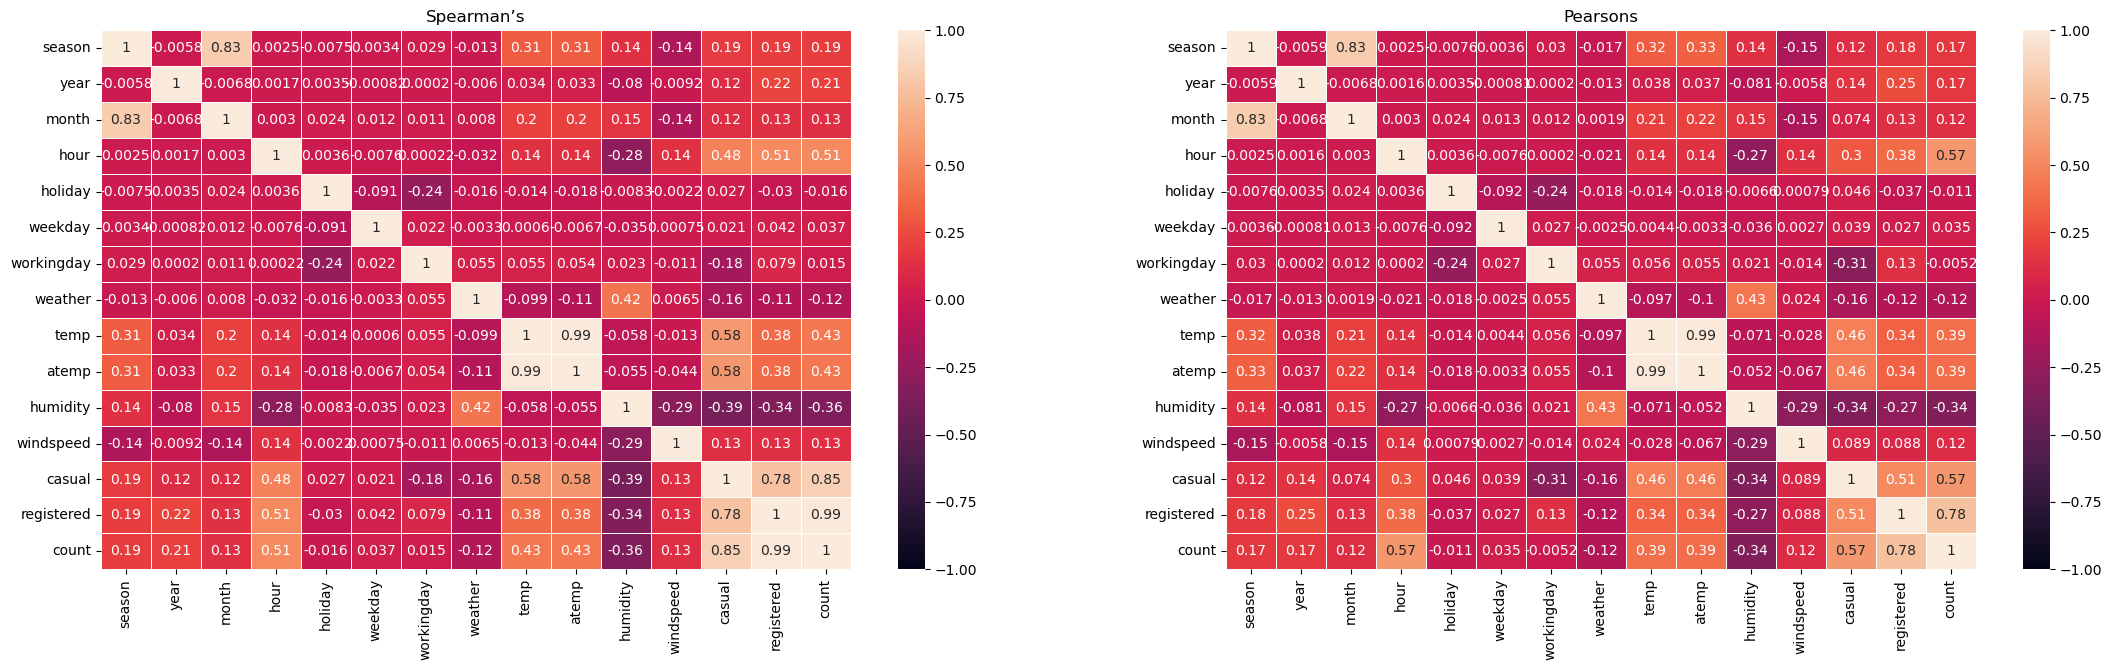

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))
plt.subplots_adjust(right=1.5)

columns = df_train.columns.values
SpearCorr = df_train[columns].corr(method='spearman')

ax1.set_title("Spearman’s")
sns.heatmap( SpearCorr, annot=True, vmin=-1 , vmax=1 , linewidths=0.5 , ax=ax1)

PearsonCorr = df_train[columns].corr()
ax2.set_title("Pearsons")
sns.heatmap(PearsonCorr, annot=True, vmin=-1 , vmax=1 , linewidths=0.5 , ax=ax2)

- The corleation heatmaps further show us that atemp and temp has a very high corelation so we will drop on of these, because they increase the standard error and variance which  make the solver’s job harder.
- Season and month have a high corelation aswell so once again we will remove one of these for the same reason explained above.
- We also see that registered, count and casual have a high corelation between eachother however there is no need to drop any of these as they are all targets.
- Made a decision to drop workingday as you can tell if its a working day based on weekend and holiday results.

### Dropping temp, season and workinday

In [16]:
# Drop from data frame 
df_train = df_train.drop(['temp','season','workingday','month'], axis=1 )
print("Columns in train dataframe", df_train.columns.values)


df_test = df_test.drop(['temp','season','workingday','month'], axis=1 )
print("Columns in test dataframe", df_test.columns.values)

# Drop from predictors
X_train = X_train.drop(['temp','season','workingday','month'],axis=1)
print("Features Train:", X_train.columns.values)


X_test = X_test.drop(['temp','season','workingday','month'],axis=1)
print("Features Test:", X_train.columns.values)


Columns in train dataframe ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed' 'casual' 'registered' 'count']
Columns in test dataframe ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed' 'casual' 'registered' 'count']
Features Train: ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed']
Features Test: ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed']


 - Decided to drop temp as atemp is the actual temperature felt on the day which might affect poeples choises for renting bikes more than the forecasted temp.
 - Decided to drop season over month as season is less specific than month

In [ ]:
### initate model
scale
compare


##End of Answer 2##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

##Start of Answer 3##

### Configure template model, so we an later configure it for sepcific fits

In [17]:
model = linear_model.LinearRegression()

### Scale the Features

#### Standard Scaler

In [18]:
standard_scaler = StandardScaler()

X_train_standard_arr = standard_scaler.fit_transform(X_train) 
X_train_standard = pd.DataFrame(X_train_standard_arr, index=X_train.index, columns=X_train.columns) # Convert it back to df from array

X_test_standard_arr = standard_scaler.transform(X_test)
X_test_standard = pd.DataFrame(X_test_standard_arr, index=X_test.index, columns=X_test.columns) # Convert it back to df  from array


X_train_standard.head(3)

,year,hour,holiday,weekday,weather,atemp,humidity,windspeed
14834,0.999712,-0.659663,-0.166116,1.483210,-0.664640,0.228375,-0.553218,0.761401
8912,0.999712,-0.949172,-0.166116,0.487432,2.474039,-0.738566,1.578069,-0.818319
7644,-1.000288,-1.238681,-0.166116,-1.504125,0.904699,-0.387057,0.174538,0.761401


#### MinMax Scaler

In [19]:
minmax_scaler = MinMaxScaler()

X_train_minmax_arr = minmax_scaler.fit_transform(X_train) 
X_train_minmax = pd.DataFrame(X_train_minmax_arr, index=X_train.index, columns=X_train.columns) # Convert it back


X_train_minmax.head(3)

,year,hour,holiday,weekday,weather,atemp,humidity,windspeed
14834,1.0,0.304348,0.0,1.000000,0.0,0.5152,0.52,0.339316
8912,1.0,0.217391,0.0,0.666667,1.0,0.3485,0.93,0.107203
7644,0.0,0.130435,0.0,0.000000,0.5,0.4091,0.66,0.339316


### Create findNextBestPredictor func and use it to compare two different scaling approaches

In [20]:
def findNextBestPredictor(X,y,foundPredictors):
    nP = X.shape[1] # number of columns in X
    allPredictors = list(X) # See https://stackoverflow.com/a/19483025
    predictorsToSearch = set(allPredictors) - set(foundPredictors)
    maxScore = 0 # can usually do better than this!
    for predictor in predictorsToSearch: # loop over all remaining columns (predictors) in X
        trialPredictors = set(foundPredictors)
        trialPredictors.add(predictor) # Add this predictor to the existing predictors
        XcolSubset = X.loc[:,list(trialPredictors)] # all rows and just the trial predictors
        model.fit(XcolSubset, y) # fit the model to y
        score = model.score(XcolSubset, y)
        if score > maxScore: # identify the largest score and its associated predictor
            maxScore = score
            bestPredictorFound = predictor
    
    return (maxScore, bestPredictorFound)

print("Standard Scaler:",findNextBestPredictor(X_train_standard,y_train['count'],list()))
print("MinMax Scaler:", findNextBestPredictor(X_train_minmax,y_train['count'],list()))
print("No Scalling:", findNextBestPredictor(X_train, y_train['count'],list()))

Standard Scaler: (0.3206226511361153, 'hour')
MinMax Scaler: (0.3206226511361153, 'hour')
No Scalling: (0.3206226511361153, 'hour')


#### Both Standard Scaler and MinMax Scaler show the same percentages so we can choose either of them, Standars Scaler was chosen for this project

### Compare the next best predictors for our 3 targets

In [21]:
def nextBestPredictor(X, y):
    nP = X_train.shape[1]
    scores = [0]
    foundPredictors = list()

    for i in range(nP): # loop over all columns (predictors) in X
        (score, bestPredictorFound) = findNextBestPredictor(X, y, foundPredictors)
        foundPredictors.append(bestPredictorFound)
        scores.append(score)
        print(foundPredictors, score)
        
    plt.title("Score versus predictors")
    plt.xlabel('Number of predictors') 
    plt.ylabel('R squared')
    plt.plot(scores)

['hour'] 0.3206226511361153
['hour', 'atemp'] 0.4189786035772317
['hour', 'atemp', 'humidity'] 0.45316263120142386
['hour', 'atemp', 'humidity', 'year'] 0.47380138412081996
['hour', 'atemp', 'humidity', 'year', 'weekday'] 0.4749159751978984
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed'] 0.4754566697506106
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday'] 0.4754898003155287
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday', 'weather'] 0.4755154712686763


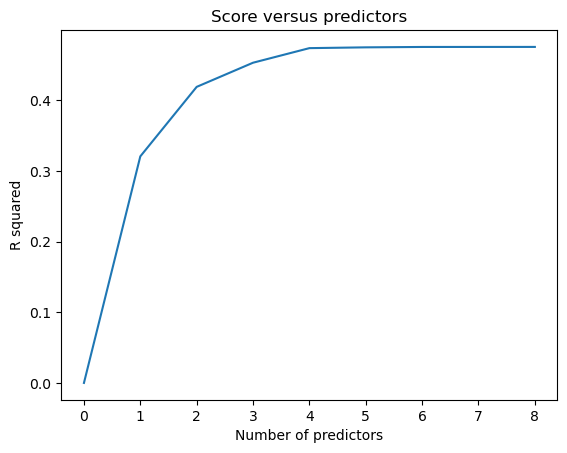

In [22]:
nextBestPredictor(X_train_standard, y_train['count'])

['hour'] 0.3206226511361153
['hour', 'atemp'] 0.4189786035772317
['hour', 'atemp', 'humidity'] 0.45316263120142386
['hour', 'atemp', 'humidity', 'year'] 0.47380138412081996
['hour', 'atemp', 'humidity', 'year', 'weekday'] 0.4749159751978983
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed'] 0.4754566697506106
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday'] 0.4754898003155287
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday', 'weather'] 0.4755154712686763


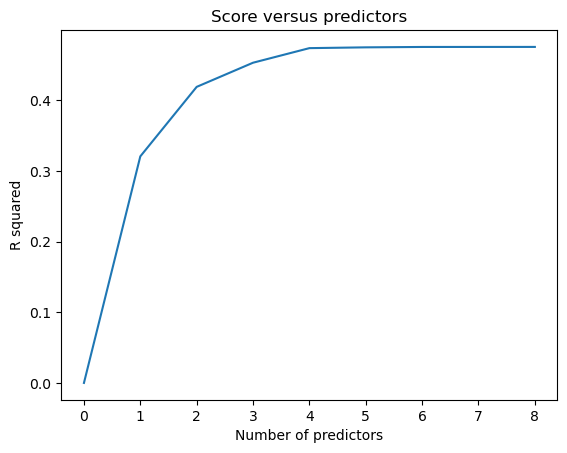

In [23]:
nextBestPredictor(X_train, y_train['count'])

['hour'] 0.3206226511361153
['hour', 'atemp'] 0.4189786035772317
['hour', 'atemp', 'humidity'] 0.45316263120142386
['hour', 'atemp', 'humidity', 'year'] 0.47380138412081996
['hour', 'atemp', 'humidity', 'year', 'weekday'] 0.4749159751978984
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed'] 0.4754566697506106
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday'] 0.4754898003155287
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday', 'weather'] 0.4755154712686763


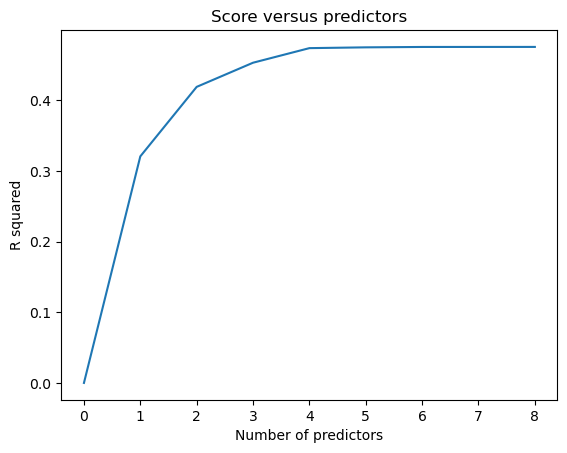

In [24]:
nextBestPredictor(X_train_minmax, y_train['count'])

['hour'] 0.1436530402879156
['hour', 'atemp'] 0.22783963904118343
['hour', 'atemp', 'year'] 0.28728350752049936
['hour', 'atemp', 'year', 'humidity'] 0.31063038702631507
['hour', 'atemp', 'year', 'humidity', 'month'] 0.31984806014974476
['hour', 'atemp', 'year', 'humidity', 'month', 'holiday'] 0.32129174280983575
['hour', 'atemp', 'year', 'humidity', 'month', 'holiday', 'windspeed'] 0.32233189925814865
['hour', 'atemp', 'year', 'humidity', 'month', 'holiday', 'windspeed', 'weekday'] 0.3226989964826521
['hour', 'atemp', 'year', 'humidity', 'month', 'holiday', 'windspeed', 'weekday', 'weather'] 0.32286344687322677


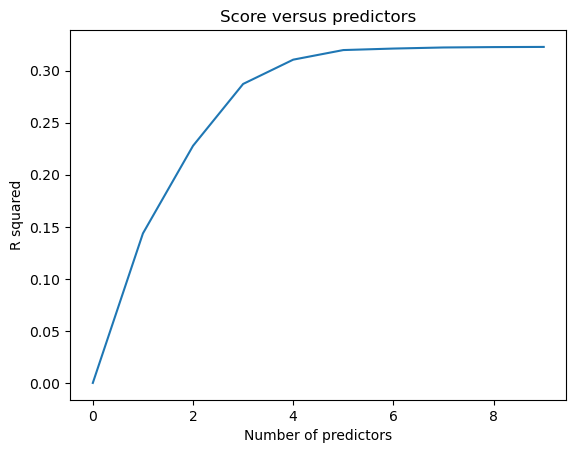

In [23]:
nextBestPredictor(X_train_standard, y_train['registered'])

['atemp'] 0.20920439449359363
['atemp', 'humidity'] 0.3121829305975563
['atemp', 'humidity', 'hour'] 0.33667736628466816
['atemp', 'humidity', 'hour', 'year'] 0.3477134659354487
['atemp', 'humidity', 'hour', 'year', 'holiday'] 0.3503155671111633
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday'] 0.3516586722652473
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday', 'month'] 0.352261197510642
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday', 'month', 'windspeed'] 0.35269639172753986
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday', 'month', 'windspeed', 'weather'] 0.3527071890264263


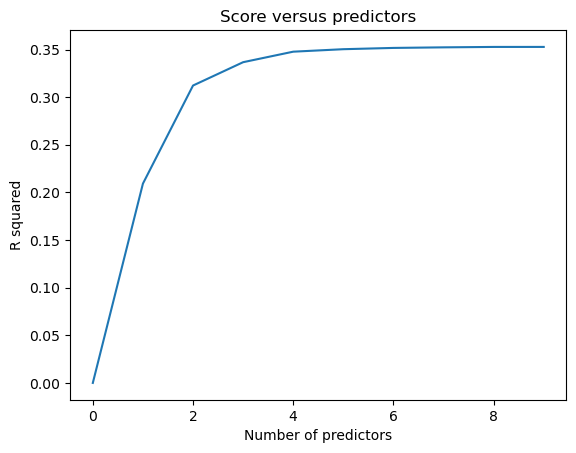

In [24]:
nextBestPredictor(X_train_standard, y_train['casual'])

### Model Fit for Count Target

In [25]:
model.fit(X_train_standard, y_train['count'])
predictors = X_train_standard.columns
coef = pd.Series(model.coef_,predictors).sort_values()
coef

humidity    -0.272842
holiday     -0.012640
weather     -0.002613
weekday      0.046326
windspeed    0.048874
month        0.129564
year         0.216061
atemp        0.433652
hour         0.701004
dtype: float64

#### Both humidity and atemp model coefficients  have large avlues with oppsoite signs which is a problem. The high values and opposite signs means theat the two are corelaated and that we missed itduring the EDA. This can be adresssed by removing one of the features or regularisation which penalises the two coefficients.


### Regularisation for Count Using Ridge Regression 

In [26]:
# assign lambda (or alpha as is used in Ridge())
ridgeReg = Ridge(alpha=100)

# Now compute the ridge regression using X, the full matrix of predictors, and y
ridgeReg.fit(X_train_standard, y_train['count'])

ridgeReg.score(X_train_standard, y_train['count'])

0.4824385576425678

In [27]:
ridge_coef = pd.Series(ridgeReg.coef_,predictors).sort_values()
ridge_coef

humidity    -0.271552
holiday     -0.012580
weather     -0.003596
weekday      0.045885
windspeed    0.049284
month        0.128870
year         0.214219
atemp        0.430546
hour         0.695039
dtype: float64

In [29]:
cv_score_count = model_selection.cross_val_score(model, X_train_standard,y_train['count'], cv=10, n_jobs=-1)
print(cv_score_count)

[0.48318173 0.49982424 0.47100175 0.51189275 0.44933776 0.47487476
 0.46512088 0.49887128 0.44801664 0.50814524]


In [30]:
y_predict = model.predict(X_test)
y_predict

array([15.88664929, 16.90452094,  6.43600264, ..., 14.68001433,
       13.28797069, 18.87850833])

### Model Fit for Casual  Target 

In [31]:
model.fit(X_train_standard, y_train['casual'])
predictors = X_train_standard.columns
coef = pd.Series(model.coef_,predictors).sort_values()
coef

humidity    -13.356502
weather       0.186187
windspeed     1.074934
month         1.385374
weekday       1.815927
holiday       2.683704
year          5.295350
hour          8.238227
atemp        20.702863
dtype: float64

#### Note: the values here are higher as they were not transformed with log. We can also see  humidity and atemp have a high corelation we wont be doing any regularisation as this isnt the preffered target.

In [32]:
cv_score_casual = model_selection.cross_val_score(model, X_train_standard,y_train['casual'], cv=10, n_jobs=-1)
print(cv_score_casual)

[0.35499575 0.34405156 0.35811825 0.34410912 0.34990165 0.35891257
 0.34453169 0.35430201 0.33207896 0.36499818]


### Model Fit for Registered Target 

In [33]:
model.fit(X_train_standard, y_train['registered'])
predictors = X_train_standard.columns
coef = pd.Series(model.coef_,predictors).sort_values()
coef

humidity    -24.165899
holiday      -5.506777
weather      -2.195650
weekday       2.942629
windspeed     5.478249
month        15.580397
year         35.173867
atemp        39.315345
hour         44.469865
dtype: float64

#### Note: the values here are higher as they were not transformed with log. We can also see  humidity and hour have a high corelation we wont be doing any regularisation as this isnt the preffered target.

In [34]:
cv_score_registered = model_selection.cross_val_score(model, X_train_standard,y_train['registered'], cv=10, n_jobs=-1)
print(cv_score_registered)

[0.35628334 0.33023035 0.30982592 0.32476473 0.28635208 0.3163279
 0.30707338 0.33225814 0.29062289 0.36356563]


##End of Answer 3##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

In [36]:
print(f"Accuracy CV for Registered mean score: {cv_score_registered.mean():.2%}  std: {cv_score_registered.std():.2%}")
print(f"Accuracy CV for Casual mean score: {cv_score_casual.mean():.2%}  std: {cv_score_casual.std():.2%}")
print(f"Accuracy CV for Count mean score: {cv_score_count.mean():.2%}  std: {cv_score_count.std():.2%}")

Accuracy CV for Registered mean score: 32.17%  std: 2.40%
Accuracy CV for Casual mean score: 35.06%  std: 0.91%
Accuracy CV for Count mean score: 48.10%  std: 2.20%


#### The Cross Validation accuracy seems to be the best for count meaning it would be the easiest to predict accurately

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

##Start of Answer 5##

##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles

##Start of Answer 6

##End of Answer 6##

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

##Start of Answer 7

##End of Answer 7##